**LLM Evaluation Framework**
A library for easily evaluating machine learning models and datasets.

With a single line of code, you get access to dozens of evaluation methods for different domains. Be it on your local machine or in a distributed training setup, you can evaluate your models in a consistent and reproducible way!

In [1]:
!pip install evaluate
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which i

In [2]:
import warnings
warnings.filterwarnings("ignore")

exmaples of evaluate

In [3]:
import evaluate
print(evaluate.load('exact_match').compute(references=['hello'],predictions=['hell']))

{'exact_match': 0.0}


**Types of evaluations**
There are different aspects of a typical machine learning pipeline that can be evaluated and for each aspect 🤗 Evaluate provides a tool:

**Metric:** A metric is used to evaluate a model’s performance and usually involves the model’s predictions as well as some ground truth labels. You can find all integrated metrics at evaluate-metric.
**Comparison:** A comparison is used to compare two models. This can for example be done by comparing their predictions to ground truth labels and computing their agreement. You can find all integrated comparisons at evaluate-comparison.
**Measurement:** The dataset is as important as the model trained on it. With measurements one can investigate a dataset’s properties. You can find all integrated measurements at evaluate-measurement.
Each metric, comparison, and measurement is a separate Python module, but for using any of them, there is a single entry point: **evaluate.load()**

In [4]:
import evaluate
accuracy = evaluate.load("accuracy")
word_length = evaluate.load("word_length",module_type="measurement")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
data = ["hello world"]
results = word_length.compute(data=data)
print(results)

{'average_word_length': 2}


In [7]:
accuracy.compute(references=[1,0,0,1],predictions=[1,0,0,1])

{'accuracy': 1.0}

If you have model Actual Results and Predictions, you can calculate the Accuracy as below

In [8]:
for refs, preds in zip([[0,1],[0,1]], [[1,0],[0,1]]):
    accuracy.add_batch(references=refs, predictions=preds)
accuracy.compute()

{'accuracy': 0.5}

**Combining several evaluations**

In [9]:
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

In [10]:
clf_metrics.compute(predictions=[0,1,0],references=[0,1,1])

{'accuracy': 0.6666666666666666,
 'f1': 0.6666666666666666,
 'precision': 1.0,
 'recall': 0.5}

Saving the Result in File

In [12]:
result = accuracy.compute(references=[0,1,0,1], predictions=[1,0,0,1])

hyperparams = {"model": "bert-base-uncased"}
evaluate.save("/kaggle/working/",experiment="run 42", **result, **hyperparams)

PosixPath('/kaggle/working/result-2024_08_24-15_29_18.json')

In [14]:
!pip install datasets

In [17]:
from transformers import pipeline
from datasets import load_dataset
from evaluate import evaluator
import evaluate



pipe = pipeline("text-classification",model="lvwerra/distilbert-imdb", device=0)
data = load_dataset("imdb",split="test").shuffle().select(range(1000))
metric = evaluate.load("accuracy")

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [18]:
task_evaluator = evaluator("text-classification")
results = task_evaluator.compute(model_or_pipeline=pipe, data=data, metric=metric,
                       label_mapping={"NEGATIVE": 0, "POSITIVE": 1},)
print(results)

{'accuracy': 0.936, 'total_time_in_seconds': 11.913310205000016, 'samples_per_second': 83.93972647336086, 'latency_in_seconds': 0.011913310205000017}


Calculating the value of the metric alone is often not enough to know if a model performs significantly better than another one. With bootstrapping evaluate computes confidence intervals and the standard error which helps estimate how stable a score is:

In [19]:
results = task_evaluator.compute(model_or_pipeline=pipe, data=data, metric=metric,
                       label_mapping={"NEGATIVE": 0, "POSITIVE": 1},
                       strategy="bootstrap", n_resamples=200)
print(results)


{'accuracy': {'confidence_interval': (0.92, 0.9503069100974394), 'standard_error': 0.0076876442667346894, 'score': 0.936}, 'total_time_in_seconds': 10.350583390999873, 'samples_per_second': 96.61291177746836, 'latency_in_seconds': 0.010350583390999873}


The evaluator expects a "text" and "label" column for the data input. If your dataset differs you can provide the columns with the keywords input_column="text" and label_column="label". Currently only "text-classification" is supported with more tasks being added in the future.

**Visualize the Evaluation of Different Models**

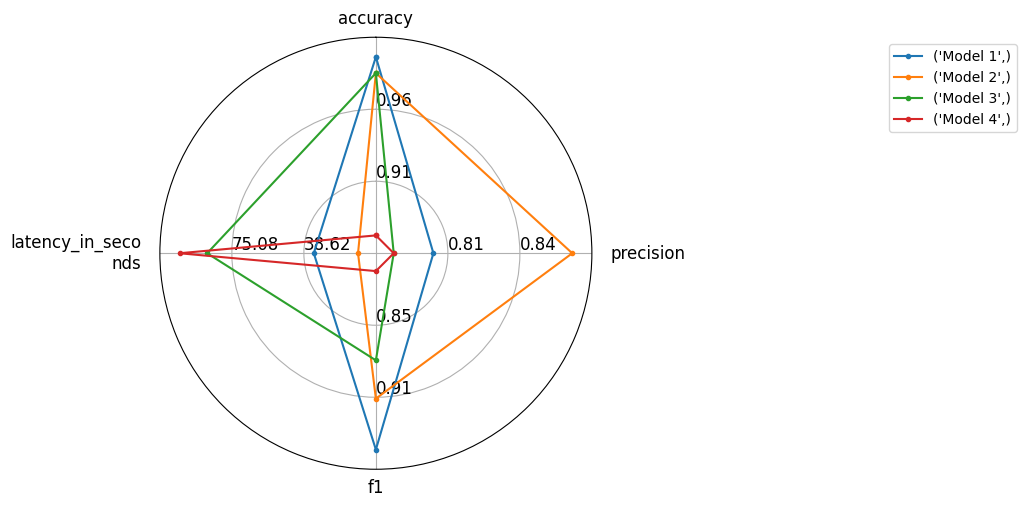

In [20]:
import evaluate
from evaluate.visualization import radar_plot

data = [
    {"accuracy": 0.99, "precision": 0.8, "f1": 0.95, "latency_in_seconds": 33.6},
   {"accuracy": 0.98, "precision": 0.87, "f1": 0.91, "latency_in_seconds": 11.2},
   {"accuracy": 0.98, "precision": 0.78, "f1": 0.88, "latency_in_seconds": 87.6},
   {"accuracy": 0.88, "precision": 0.78, "f1": 0.81, "latency_in_seconds": 101.6}
]
model_names = ["Model 1", "Model 2", "Model 3", "Model 4"]
plot = radar_plot(data=data, model_names=model_names)
plot.show()

**Choosing a Metric for your task**
So you’ve trained your model and want to see how well it’s doing on a dataset of your choice. Where do you start?

There is no “one size fits all” approach to choosing an evaluation metric, but some good guidelines to keep in mind are:


**Categories of Metrics**
There are 3 high-level categories of metrics:

**Generic metrics**, which can be applied to a variety of situations and datasets, such as precision and accuracy.
**Task-specific metrics**, which are limited to a given task, such as Machine Translation (often evaluated using metrics BLEU or ROUGE) or Named Entity Recognition (often evaluated with seqeval).
**Dataset-specific metrics**, which aim to measure model performance on specific benchmarks: for instance, the GLUE benchmark has a dedicated evaluation metric.


**Generic metrics**
Many of the metrics used in the Machine Learning community are quite generic and can be applied in a variety of tasks and datasets.

This is the case for metrics like accuracy and precision, which can be used for evaluating labeled (supervised) datasets, as well as perplexity, which can be used for evaluating different kinds of (unsupervised) generative tasks.

In [21]:
precision_metric = evaluate.load("precision")
results = precision_metric.compute(references=[0, 1], predictions=[0, 1])
print(results)


{'precision': 1.0}


**Task-specific metrics**
Popular ML tasks like Machine Translation and Named Entity Recognition have specific metrics that can be used to compare models.

For example, a series of different metrics have been proposed for text generation, ranging from BLEU and its derivatives such as GoogleBLEU and GLEU, but also ROUGE, MAUVE, etc.
You can find the right metric for your task by:

Looking at the Task pages to see what metrics can be used for evaluating models for a given task.
Checking out leaderboards on sites like Papers With Code (you can search by task and by dataset).
Reading the metric cards for the relevant metrics and see which ones are a good fit for your use case. For example, see the BLEU metric card or SQuaD metric card.
Looking at papers and blog posts published on the topic and see what metrics they report. This can change over time, so try to pick papers from the last couple of years!

In [22]:
def evaluate_machine_translation(hypotheses, references):
    """
    Calculates BLEU score for machine translation evaluation.
    Args:
    hypotheses (List[str]): List of translated sentences.
    references (List[List[str]]): List of reference translations for each input sentence.

    Returns:
    float: BLEU score.
    """
    # Use HF Eval's `load` function to get the BLEU evaluator
    bleu_evaluator = evaluate.load("bleu")

    # Calculate BLEU score using the evaluator
    results = bleu_evaluator.compute(predictions=hypotheses, references=references)

    # Extract BLEU score (average across references)
    bleu_score = results["bleu"]

    return bleu_score

In [23]:
# Example hypotheses (translated sentences)
hypotheses = ["The cat sat on mat.", "The dog played in garden."]

# Example references (reference translations for each input sentence)
references = [["The cat sat on the mat."], ["The dog played in the garden."]]

# Calculate BLEU score
bleu_score = evaluate_machine_translation(hypotheses, references)

# Print the BLEU score
print("BLEU Score:", bleu_score)

BLEU Score: 0.5115078115793242


This indicates the overall BLEU score. It reflects the cumulative n-gram precision of the generated translations or summaries compared to the reference translations or summaries, where n typically ranges from 1 to 4. A score of approximately 0.51 indicates that around 51.15% of the n-grams (typically up to 4-grams) in the generated translations or summaries match those in the reference translations or summaries.

In [25]:
from sklearn.metrics import classification_report

def evaluate_ner(true_labels, predicted_labels):
    """
    Evaluate the performance of a Named Entity Recognition system.

    Args:
    true_labels (list of lists): True labels for each sentence in the dataset.
    predicted_labels (list of lists): Predicted labels for each sentence in the dataset.

    Returns:
    classification_report (str): Text summary of precision, recall, and F1 score for each class.
    """
    # Flatten the lists of labels
    true_labels_flat = [label for sublist in true_labels for label in sublist]
    predicted_labels_flat = [label for sublist in predicted_labels for label in sublist]

    # Generate classification report
    report = classification_report(true_labels_flat, predicted_labels_flat)

    return report
true_labels = [['N', 'B-PER', 'I-PER', 'O'], ['B-LOC', 'I-LOC', 'N']]
predicted_labels = [['O', 'B-PER', 'I-PER', 'O'], ['B-LOC', 'I-LOC', 'O']]

evaluation_result = evaluate_ner(true_labels, predicted_labels)
print(evaluation_result)


              precision    recall  f1-score   support

       B-LOC       1.00      1.00      1.00         1
       B-PER       1.00      1.00      1.00         1
       I-LOC       1.00      1.00      1.00         1
       I-PER       1.00      1.00      1.00         1
           N       0.00      0.00      0.00         2
           O       0.33      1.00      0.50         1

    accuracy                           0.71         7
   macro avg       0.72      0.83      0.75         7
weighted avg       0.62      0.71      0.64         7



In [26]:
import evaluate

def simple_summarizer(text):
    sentences = text.split(".")
    return sentences[0]

# Load ROUGE metric
rouge_scorer = evaluate.load("rouge")

# Example text and reference summary
text = "Today is a beautiful day. The sun is shining and the birds are singing. I am going for a walk in the park."
reference = "The weather is pleasant today."

# Generate summary using the function
prediction = simple_summarizer(text)

# Compute ROUGE score
rouge_results = rouge_scorer.compute(predictions=[prediction], references=[reference])

# Print ROUGE score (might be very low due to the simplistic summarizer)
print("ROUGE-L score:", rouge_results["rougeL"])
print("ROUGE-1 score:", rouge_results["rouge1"])
print("ROUGE-2 score:", rouge_results["rouge2"])


ROUGE-L score: 0.20000000000000004
ROUGE-1 score: 0.4000000000000001
ROUGE-2 score: 0.0


ROUGE-L score:This indicates the ROUGE-L score, which measures the overlap of Longest Common Subsequences (LCS) between the generated summaries and the reference summaries. The score of 0.20000000000000004 suggests that approximately 20% of the content in the generated summaries matches the content in the reference summaries, but there's significant room for improvement.

ROUGE-1 score: This is the ROUGE-1 score, which measures the overlap of unigrams (individual words) between the generated summaries and the reference summaries. The score of 0.4000000000000001 suggests that approximately 40% of the unigrams in the generated summaries match those in the reference summaries.

ROUGE-2 score: This is the ROUGE-2 score, which measures the overlap of bigrams (pairs of adjacent words) between the generated summaries and the reference summaries. The score of 0.0 suggests that there is no overlap of bigrams between the generated and reference summaries, indicating that the generated summaries did not contain any two-word sequences that matched those in the reference summaries.

**Dataset-specific metrics**
Some datasets have specific metrics associated with them — this is especially in the case of popular benchmarks like GLUE and SQuAD.

**GLUE is actually a collection of different subsets on different tasks, so first you need to choose the one that corresponds to the "Natural Language Inference" NLI task, such as mnli, which is described as “crowdsourced collection of sentence pairs with textual entailment annotations”**

In [27]:
from evaluate import load
squad_metric = load("squad")
predictions = [{'prediction_text': '1976', 'id': '56e10a3be3433e1400422b22'}]
references = [{'answers': {'answer_start': [97], 'text': ['1976']}, 'id': '56e10a3be3433e1400422b22'}]
results = squad_metric.compute(predictions=predictions, references=references)
results

{'exact_match': 100.0, 'f1': 100.0}

**Using Evaluator**
The Evaluator classes allow to evaluate a triplet of model, dataset, and metric. The models wrapped in a pipeline, responsible for handling all preprocessing and post-processing and out-of-the-box, Evaluators support transformers pipelines for the supported tasks.

In [30]:
from datasets import load_dataset
from evaluate import evaluator
from transformers import AutoModelForSequenceClassification, pipeline

# Load and shuffle the dataset
data = load_dataset("imdb", split="test").shuffle(seed=42).select(range(1000))

# Initialize the task evaluator
task_evaluator = evaluator("text-classification")

# Create the pipeline and specify the device (0 for GPU)
pipe = pipeline("text-classification", model="lvwerra/distilbert-imdb", device=0)

# Compute the evaluation results
eval_results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=data,
    label_mapping={"NEGATIVE": 0, "POSITIVE": 1}
)

# Print the evaluation results
print(eval_results)


{'accuracy': 0.918, 'total_time_in_seconds': 10.340099074000136, 'samples_per_second': 96.71087219216976, 'latency_in_seconds': 0.010340099074000136}


**Running Evaluation Suit on GPT2 LLM**

In [31]:
from evaluate import EvaluationSuite
suite = EvaluationSuite.load('mathemakitten/glue-evaluation-suite')
results = suite.run("gpt2")

Generating train split:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1063 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating train split:   0%|          | 0/363846 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/40430 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/390965 [00:00<?, ? examples/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating train split:   0%|          | 0/104743 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5463 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5463 [00:00<?, ? examples/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating train split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/277 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating train split:   0%|          | 0/635 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/71 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/146 [00:00<?, ? examples/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
results

[{'accuracy': 0.0,
  'total_time_in_seconds': 0.3912924079995719,
  'samples_per_second': 25.556335353204556,
  'latency_in_seconds': 0.039129240799957186,
  'task_name': 'glue/cola',
  'data_preprocessor': None},
 {'accuracy': 0.5,
  'total_time_in_seconds': 0.08126522199972896,
  'samples_per_second': 123.05386921890587,
  'latency_in_seconds': 0.008126522199972896,
  'task_name': 'glue/sst2',
  'data_preprocessor': None},
 {'accuracy': 0.6,
  'total_time_in_seconds': 0.08361086400009299,
  'samples_per_second': 119.60168238410834,
  'latency_in_seconds': 0.008361086400009298,
  'task_name': 'glue/qqp',
  'data_preprocessor': None},
 {'accuracy': 0.4,
  'total_time_in_seconds': 0.09903566899993166,
  'samples_per_second': 100.97372089248876,
  'latency_in_seconds': 0.009903566899993166,
  'task_name': 'glue/mrpc',
  'data_preprocessor': None},
 {'accuracy': 0.3,
  'total_time_in_seconds': 0.09849411899995175,
  'samples_per_second': 101.52890448215389,
  'latency_in_seconds': 0.00984